# Diseño Básico de Vigas de Hormigón Armado en Python
## Proyecto: Aplicación para diseño estructural (Flexión simple y Cortante)
### 1. INTRODUCCIÓN:
El objetivo de este trabajo es desarrollar una aplicación en Python (Jupyter Notebook) que realice el diseño básico de vigas de hormigón armado sometidas a esfuerzos de flexión simple y cortante, aplicando los criterios de resistencia admisible de las normas ACI 318.


### 2. OBJETIVOS:
- Calcular las solicitaciones (momentos y cortantes) aplicadas a una viga.

- Determinar la capacidad resistente del elemento a flexión y cortante.

- Calcular la cantidad de acero de refuerzo necesaria para cumplir con la resistencia requerida.

- Graficar los diagramas de Momento flector, Cortante y la elástica.

- Crear una interfaz con el usuario para la toma de datos.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### 3. FUNDAMENTOS TEÓRICOS:
#### 3.1. Diagrama de esfuerzos: 
3.1.1. Para una viga simplemente apoyada con carga distribuida $w$ y carga puntual $P$, el Momento y el cortante, en una posición dada de la barra (de longitud $l$), es:
- Ecuación de equilibrio de fuerzas verticales:
$$\sum F_y = 0: R_A + R_B - w*L - \sum p_i = 0$$
- Momento alrededor del apoyo A:
$$\sum M_A = 0: R_B*L - \frac{w*L^2}{2} - \sum p_i*(x_i) = 0$$
- De aquí que:
$$R_B = \frac{w*L^2}{2*L} + \sum p_i*\frac{(x_i)}{L} = \frac{w*L}{2} + \sum p_i*\frac{(x_i)}{L}$$
$$R_A = \frac{w*L}{2} + \sum p_i*\frac{(L - x_i)}{L}$$


- $R_A$ y $R_B$ son las reacciones en los apoyos/extremos de la viga.
- $V(x)$: Fuerza Cortante en la sección "$x$".
- $M(x)$: Momento Cortante en la sección "$x$".




### 4. DIMENSIONAMIENTO:
#### 4.1. Cálculo y verificación del dimensionamiento de una viga de hormigón armado, verificando: 

4.1.1. Resistencia a cortante.

4.1.2. Resistencia a Flexión (Momento).

4.1.3. Flecha (Deformación).

### 5. GRAFICO DE LOS DIAGRAMAS:

5.1. Diagrama de Cortante:
$$V(x) = R_A - w*x - \sum_{\xi \le x} p_i$$
5.2. Diagrama de Momento Flector Simple:
Se integra el cortante:

$$
M(x) = \int_{0}^{x} V(\xi)\, d\xi
$$

Sabiendo que:

$$
\int_{0}^{x} (R_A)\, d\xi = R_A\, x
$$

$$
\int_{0}^{x} w\,\xi \, d\xi = \frac{w x^{2}}{2}
$$

$$
\int_{0}^{x} p_i\, H(\xi - x_i)\, d\xi = p_i (x - x_i)
$$

donde \(H\) es la función escalón de Heaviside.

Entonces:

$$
M(x)
= R_A x 
- \frac{w x^{2}}{2}
- \sum_{x_i \le x} p_i (x - x_i)
$$


5.3. Elástica de deformación:
- Curvatura de la viga:

$$
\kappa(x) = \frac{1}{\rho} = \frac{M(x)}{E\,I}
$$

Donde:

\(E\) = módulo de elasticidad del material  
\(I\) = momento de inercia geométrico  
\(\rho\) = radio de curvatura. 

En el código se hace: kappa = M_Nmm / (E * I)

- Cálculo de la pendiente θ(x) — Integración

La pendiente se obtiene integrando la curvatura:

$$
\theta(x) = \int_{0}^{x} \kappa(\xi)\, d\xi
$$

En el código, la integración se hace numéricamente con el método del trapecio:

$$
\theta[i] = \theta[i-1] + \frac{\kappa_{i-1} + \kappa_i}{2}\, dx
$$
En el código, escribimos: thita[i] = thita[i-1] + 0.5*(kappa[i-1]+kappa[i])*dx_mm

- Imposición de condiciones de apoyo: \(y(0) = 0\) y \(y(L) = 0\)

La integración numérica **no respeta automáticamente las condiciones de frontera**, así que corregimos restando una recta entre los extremos:

$$
y_{\text{final}}(x) = y(x) - \left( y(0) + (y(L) - y(0)) \frac{x}{L} \right)
$$
En el código, escribimos: defl -= defl[0] + (defl[-1]-defl[0])*xs/L




### 6. Datos estructurales (Para diseño a flexión, a corte y a deflexión/flecha):

#### 6.1. Resistencia característica del hormigón. Tensión de fluencia del acero en varillas. Módulo de elasticidad del Hormigón:

Concreto:  fc′ = 25 [MPa] 

Acero: fy = 420 [MPa]

Módulo de elasticidad del hormigón: 
Ec = 25.000 [MPa]



### 7. Diseño a flexión:

#### 7.1. Flexión de viga de sección transversal rectangular, armado en tracción:

- Extraemos el momento máximo $M_u$ de diagramas( ), o sea de $M(x)$.

- Calculamos el momento nominal $M_n$ (El máximo momento que puede soportar la pieza):

​$$M_n = {A_s*f_y}*{(d - a/2)}$$ con $$a = \frac{A_s*f_y}{0.85*f'_c*b'}$$

- Calculo iterativo de $A_s$ y $a$ ($A_s$ depende de $a$).

- Factor de reducción de la resistencia del acero (varía entre 0,65 y 0,90).

- Se seleccionan el número de barras comerciales.

- Advertencias: no considera armaduras comprimidas adicionales, flecha, armado por cortante, ni comprobaciones por grietas — sólo la verificación/dimensionamiento por flexión para una viga rectangular y sección simple.
  
- Primer estimado de acero, usando $M_n ≈ A_s*f_y*d$.

- Se ajustará iterativamente porque $a$ depende de $A_s$.




### 8. Diseño a Cortante:

#### 8.1. Esfuerzo cortante de una viga de sección transversal rectangular:

- Extraemos el cortante máximo $V_u$ de diagramas( ), o sea de $V(x)$.

- Calculamos el cortante nominal $V_n$ (El máximo cortante que puede soportar la pieza):

- Se usa la fórmula simplificada   $V_c ≈ 0.17*\sqrt{f'_c}\, b_w d$ que sustituye a $V_c = 0.17 \lambda \sqrt{f'_c}\, b_w d$. Los resultados son en $[N]$.             

- Si $V_u > φV_c$ hace falta un refuerzo en acero para el cortante, un refuerzo transversal. Vs_req es la diferencia entre la demanda y capacidad del concreto.

- Se proponen estribos de 8 mm con 2 ramas (Av por cada rama calculada) y se calcula s_req (distancia entre armaduras transversales), usando:

$$s = \frac{A_vtotal*f_y*d}{V_s}$$

- Se limita s a min(d/2, 60 cm). El valor de la separación no puede ser mayor a d/2 o a 60 $[cm]$. ACI tiene límites y condiciones.


### 9. Curva de deformación - Elástica de deformación:

##### 9.1. Deformación de una viga de sección transversal rectangular:

- Convierte $M(x)$ de $[t.m]$ a $[N.m]$.

- Hallar la curvatura $k(x) = \frac{M(x)}{E*I}$ en $[1/m]$. La relación momento-curvatura de la viga es:


Diseño de Viga en ACI, digite los siguientes datos: 
Digite las cargas puntuales: 


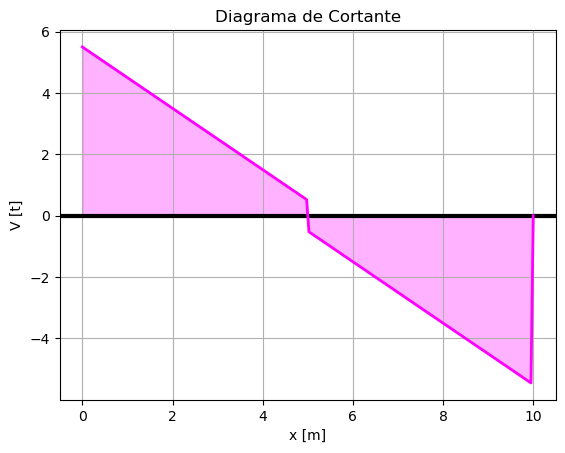

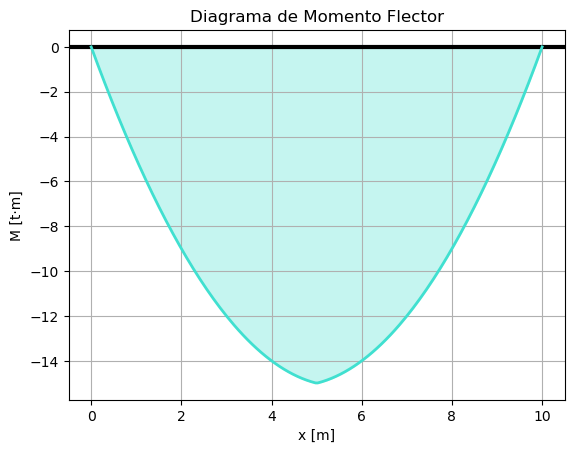

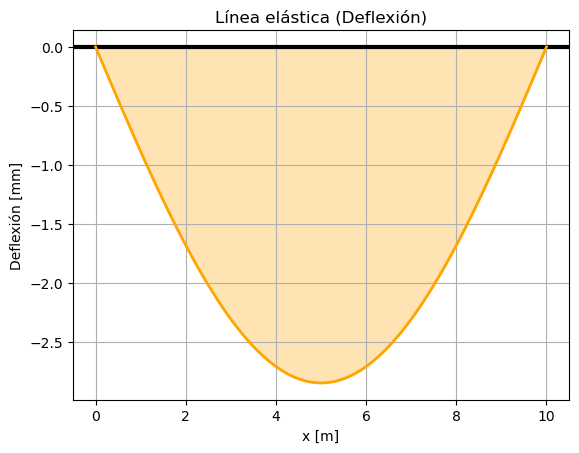

As requerido = 578.59 mm2
Profundidad efectiva d = 964.0 mm
Deflexión máxima = -2.84 mm
Resistencia del concreto Vc = 15.60 t
Corte requerido Vs = 0.00 t
Separación de estribos s = 0.0 mm


In [2]:

# Reacciones:
# Equilibrio Estático: Reacciones en RA y RB.
def fuerzas(L, P=None, w=0.0): # P es una lista de tuplas [(xp1, p1), (xp2, p2), ... , (xpn, pn)]. Posición y valor de cada carga puntual (xpi, pi)
    RA = w * L / 2 # Primeros valores de las reacciones
    RB = RA
    if P:
        for xpi, pi in P:
            RA += pi * (L - xpi) / L # A cada reacción se le suma la influencia que le dá cada carga puntual
            RB += pi * xpi / L
    return RA, RB


# Diagramas de Momentos y Cortantes:
def diagramas(L, P=None, w=0.0):
    RA, RB = fuerzas(L, P, w)
    xs = np.linspace(0, L, 200)
    V = np.zeros_like(xs)
    M = np.zeros_like(xs)
    for i, x in enumerate(xs):
        v = RA
        m = RA * x
        v -= w * x
        m -= w * x**2 / 2
        if P:
            for xpi, pi in P:
                if xpi <= x:
                    v -= pi
                    m -= pi * (x - xpi)
        if x >= L:
            v += RB
            m += RB * (x - L)
        V[i] = v
        M[i] = m
    return xs, V, M, (RA, RB)


# Diseño a flexión ACI:
def diseño_flexion(M, b_m, h_m, rec_mm, db_mm, fc_mpa, fy_mpa, seg=1.4): # M: momento en [t.m]
    if hasattr(M, '__len__'):
        Mmax = np.max(np.abs(M))
    else:
        Mmax = abs(M)

    Mu_Nmm = seg * Mmax * 9810 * 1000.0 # De [t] a [N] y de [m] a [mm]. Momento último en [N.mm]. Se mayora el momento obtenido por cálculo
    b = b_m * 1000 # De [m] a [mm]
    h = h_m * 1000 # De [m] a [mm]
    d = h - rec_mm - db_mm / 2

    fc = fc_mpa
    fy = fy_mpa

    As = Mu_Nmm / (0.9 * fy * d)

    for _ in range(100):
        a = (As * fy) / (0.85 * fc * b) # 0.85 es un factor de reducción
        Mn = As * fy * (d - a / 2)
        As_new = Mu_Nmm / (0.9 * fy * (d - a / 2))
        if abs(As_new - As) < 1e-3:
            As = As_new
            break
        As = 0.5 * (As + As_new)

    return As, d

# Diseño a corte ACI:
def diseño_corte(V, b_m, h_m, fc_mpa, fy_mpa, seg=1.25):
    b = b_m * 1000 # De [m] a [mm]
    h = h_m * 1000 # De [m] a [mm]
    d = 0.9 * h

    Vu_N = V * 9810 # de [t] a [N]
    Vc = 0.17 * (fc_mpa**0.5) * b * d / seg  # resistencia concreta
    Vs_req = max(0, Vu_N - Vc)  # N

    Av_min = 0.062 * (fc_mpa**0.5) * b / fy_mpa  # [mm2/mm]
    s = (2 * Av_min * fy_mpa * d) / Vs_req if Vs_req > 0 else 0  # [mm]

    return Vc/9810, Vs_req/9810, s  # devolver en [t] y [mm]


# Interfaz con el usuario:
def interfaz():
    print('Diseño de Viga en ACI, digite los siguientes datos: ')

    L = float(input('Digite la ongitud de la viga en [m]: '))
    w = float(input('Digite el valor de la carga distribuida w en [t/m]: '))

    print('Digite las cargas puntuales: ')
    P = []  # Primero asignamos una lista vacía
    while True:
        pregunta = input('¿Desea agregar carga puntual? Responder: (si o no): ')
        if pregunta.lower() != 'si':
            break
        xp = float(input('Digite la posición de la carga en [m]: '))
        p = float(input('Digite el valor de la carga en [t]: '))
        P.append((xp, p))

    b_m = float(input('Digite el ancho b en [m]: '))
    h_m = float(input('Altura h [m]: '))
    rec_mm = float(input('Recubrimiento [mm]: '))
    db_mm = float(input('Diámetro barra [mm]: '))

    fc = float(input('fc [MPa]: '))
    fy = float(input('fy [MPa]: '))

    xs, V, M, (RA, RB) = diagramas(L, P, w) # Variables para graficar. En realidad yo no uso RA y RB, pero si no los coloco me crea error el código.

    # Diagrama de cortante V(x):
    plt.figure()
    plt.axhline(0, color='black', linewidth=3) # La línea en y = 0, de color negro y grosor 2, cuanto mayor es linewidth mas grosor.
    plt.plot(xs, V, color='fuchsia', linewidth=2) # Grafica la curva V(x) a lo largp de xs (mismo largo) en color fuchsia y grosor 2.
    plt.fill_between(xs, V, 0, color='fuchsia', alpha=0.3) # Es el relleno de límites entre la curva V(x) e y=0 de color fuchsia y transparencia 0.2 (0 es transparente).
    plt.title('Diagrama de Cortante') # Título principal del gráfico
    plt.xlabel('x [m]')
    plt.ylabel('V [t]')
    plt.grid(True)
    plt.show()

    # Diagrama de Momento M(x):
    plt.figure()
    plt.axhline(0, color='black', linewidth=3) 
    plt.plot(xs, -M, color='turquoise', linewidth=2)
    plt.fill_between(xs, -M, 0, color='turquoise', alpha=0.3)
    plt.title('Diagrama de Momento Flector')
    plt.xlabel('x [m]')
    plt.ylabel('M [t·m]')
    plt.grid(True)
    plt.show()

    # Línea Elástica Corregida:
    E = 25000  # [MPa] Módulo de Elasticidad para el concreto (un ejemplo aprox.)
    b_mm = b_m * 1000 # De [m] a [mm]
    h_mm = h_m * 1000 # De [m] a [mm]
    I = (b_mm * h_mm**3)/12.0  # mm4
    M_Nmm = np.array(M) * 9810 * 1000 # de [t.m] a [N.mm]
    kappa = M_Nmm / (E * I)

    n = len(xs)
    dx_mm = (xs[1] - xs[0]) * 1000 # de [m] a [mm]
    thita = np.zeros(n)
    defl = np.zeros(n)
    for i in range(1, n):
        thita[i] = thita[i-1] + 0.5*(kappa[i-1]+kappa[i])*dx_mm
        defl[i] = defl[i-1] + 0.5*(thita[i-1]+thita[i])*dx_mm

    # Ajuste de condiciones de apoyo:
    defl -= defl[0] + (defl[-1]-defl[0])*xs/L

    plt.figure()
    plt.axhline(0, color='black', linewidth=3)
    plt.plot(xs, defl, color='orange', linewidth=2)
    plt.fill_between(xs, defl, 0, color='orange', alpha=0.3)
    plt.title('Línea elástica (Deflexión)')
    plt.xlabel('x [m]')
    plt.ylabel('Deflexión [mm]')
    plt.grid(True)
    plt.show()

    # Diseño a flexión. Armaduras:
    As_req, d = diseño_flexion(M, b_m, h_m, rec_mm, db_mm, fc, fy)
    print(f"As requerido = {As_req:.2f} mm2")
    print(f"Profundidad efectiva d = {d:.1f} mm")
    print(f"Deflexión máxima = {np.min(defl):.2f} mm")

    # Diseño a cortante. Armaduras:
    Vu_max = np.max(np.abs(V))
    Vc, Vs_req, s = diseño_corte(Vu_max, b_m, h_m, fc, fy)
    print(f"Resistencia del concreto Vc = {Vc:.2f} t")
    print(f"Corte requerido Vs = {Vs_req:.2f} t")
    print(f"Separación de estribos s = {s:.1f} mm")

interfaz()  
    